In [29]:
import config
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import json
import datetime

from utils.data_exploration_utils import plot_hist

In [30]:
today = datetime.date.today()

save_dir = os.path.join(proc_dir, f"{today}_hdbscan_eval")
os.makedirs(save_dir, exist_ok=True)

proc_dir = config.PROC_DATA_PATH
folder = "2025-07-22_hdbscan"

filepath = os.path.join(proc_dir, folder)

paths = []
for f in os.listdir(filepath):
    if not os.path.isdir(os.path.join(filepath, f)):
        continue
    files = os.listdir(os.path.join(filepath, f))
    for file in files:
        if file.endswith(".json"):
            paths.append(os.path.join(filepath, f, file))

In [31]:
df_l = []
for path in paths:
    with open(path, 'r') as f:
        data = json.load(f)

    eval = data['eval']
    df_dict = {
        'df_savepath': path,
        'noise_count': eval['noise_count'],
        'total_average_probability': eval['total_average_probability'],
        'normalized_total_entropy': eval['normalized_total_entropy'],
        'spearman_correlation': eval['spearman_correlation'],
        'mid_auc': eval['mid_auc'],
        'severe_auc': eval['severe_auc'],
        'nmi': eval['nmi']

    }
    df_l.append(df_dict)

df = pd.DataFrame(df_l)

df['folder_name'] = df['df_savepath'].apply(lambda x: os.path.basename(os.path.dirname(x)))

In [32]:
df.to_csv(os.path.join(save_dir, "hdbscan_eval.csv"), index=False)

# Distribution of metrics

## AUC/Spearman Rank

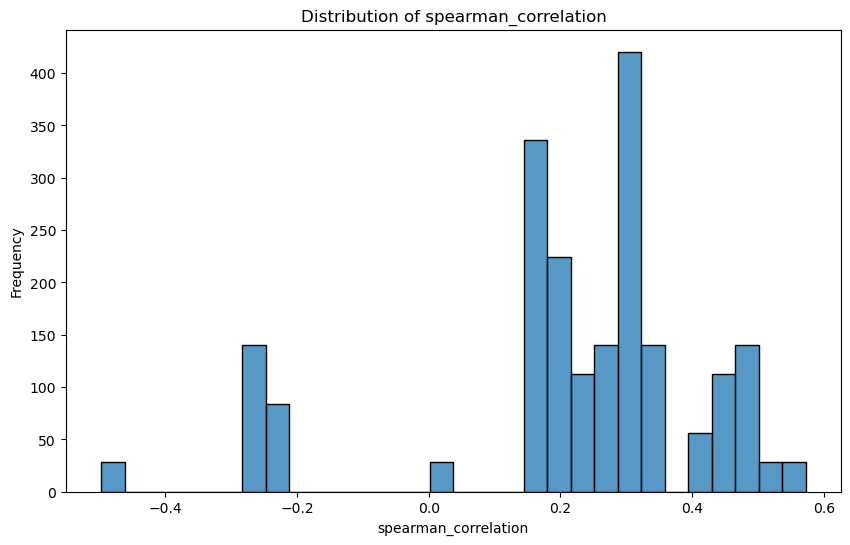

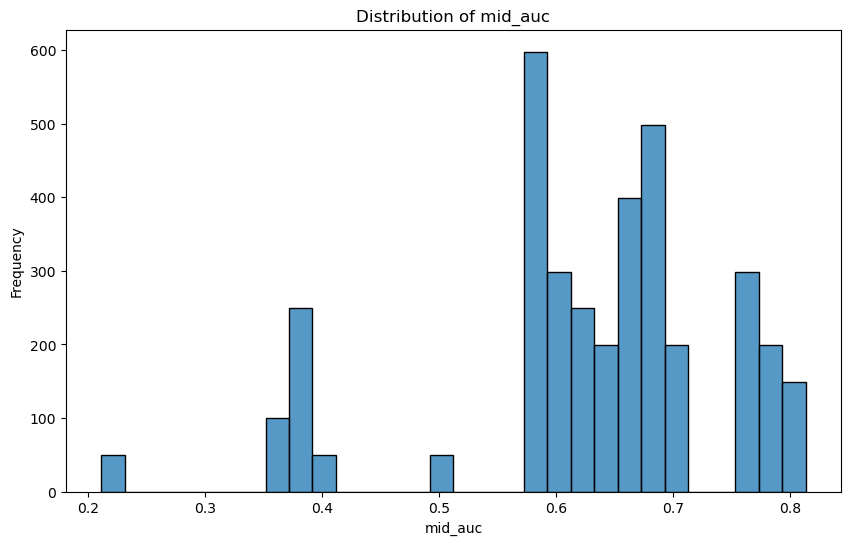

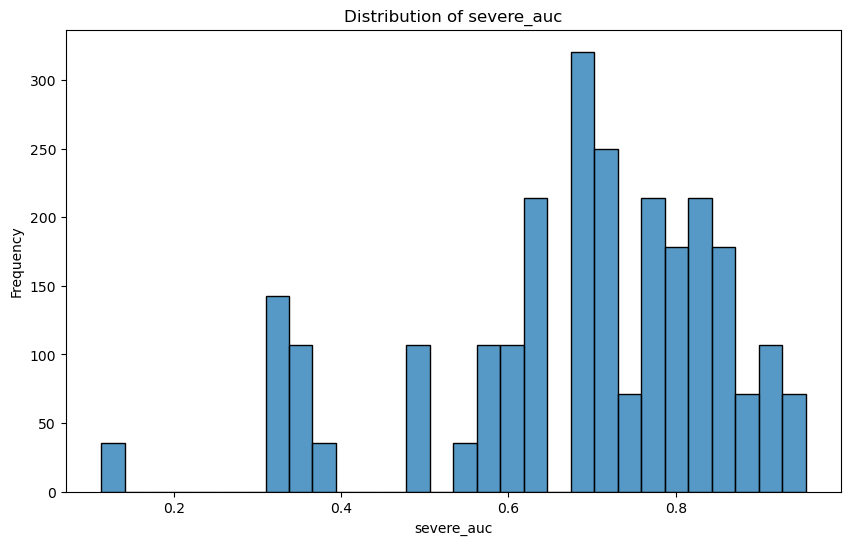

In [33]:
auc_col = ['spearman_correlation', 'mid_auc',
       'severe_auc']
for col in auc_col:
    plot_hist(df, col)

## HDBSCAN metrics

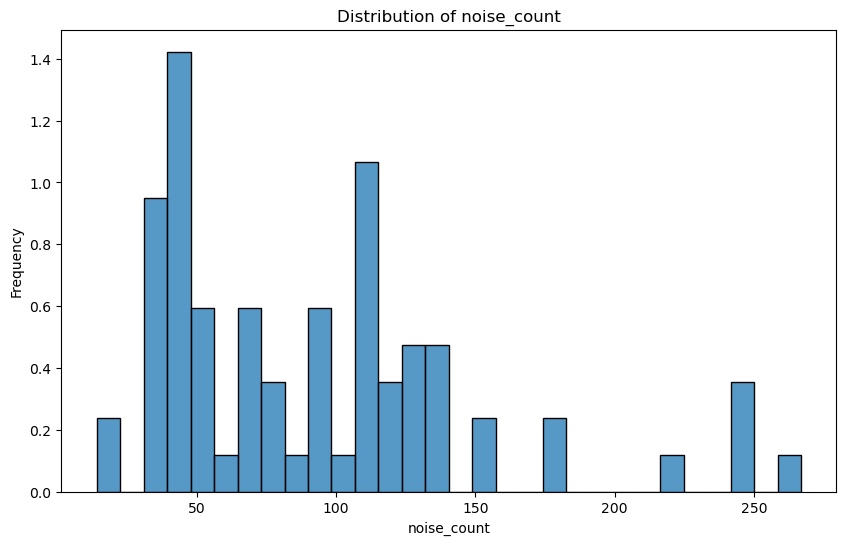

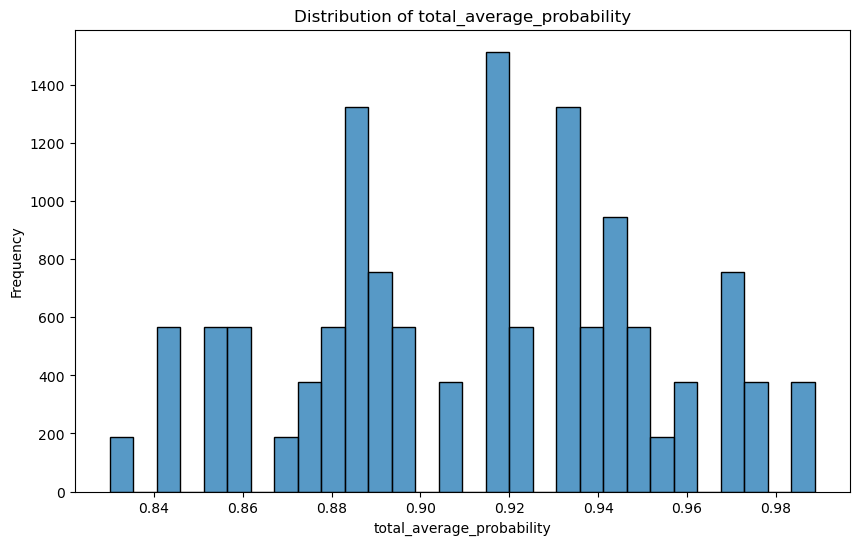

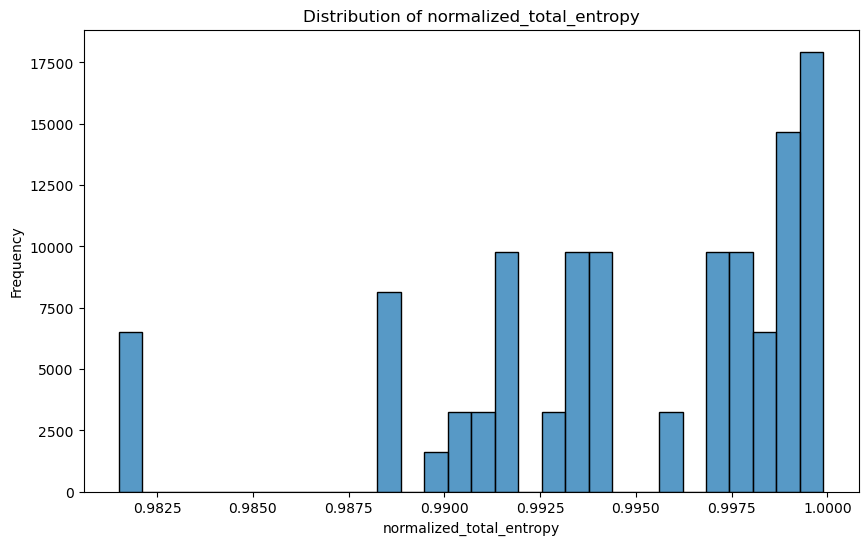

In [34]:
scan_col = ['noise_count', 'total_average_probability',
       'normalized_total_entropy']

for col in scan_col:
    plot_hist(df, col)

# xxx

## AUC

In [37]:
auc_highfolder = []
for col in auc_col:
    display(df.sort_values(col, ascending=False)[['folder_name', col]].head(10))
    auc_highfolder.append(df.sort_values(col, ascending=False)['folder_name'].head(10).tolist())

,folder_name,spearman_correlation
7,"run_60_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.572380
13,"run_72_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.533694
48,"run_69_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.489139
3,"run_70_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.489139
22,"run_54_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",0.481588
10,"run_56_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.478052
50,"run_58_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.478052
45,"run_55_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.451334
12,"run_57_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.451334
19,"run_63_umap_(15,0.5,2,'euclidean')_hdbscan_(10...",0.439875


,folder_name,mid_auc
7,"run_60_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.813348
13,"run_72_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.795312
22,"run_54_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",0.793826
3,"run_70_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.792704
48,"run_69_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.792704
10,"run_56_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.773918
50,"run_58_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.773918
29,"run_66_umap_(15,0.5,2,'euclidean')_hdbscan_(10...",0.766557
37,"run_62_umap_(15,0.5,2,'euclidean')_hdbscan_(10...",0.766557
70,"run_64_umap_(15,0.5,2,'euclidean')_hdbscan_(10...",0.762952


,folder_name,severe_auc
50,"run_58_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.955234
10,"run_56_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.955234
3,"run_70_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.916287
48,"run_69_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.916287
22,"run_54_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",0.913272
19,"run_63_umap_(15,0.5,2,'euclidean')_hdbscan_(10...",0.885666
70,"run_64_umap_(15,0.5,2,'euclidean')_hdbscan_(10...",0.885274
13,"run_72_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.867660
45,"run_55_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.863799
12,"run_57_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.863799


In [43]:
auc_l = []
# flatten list of lists
for l in auc_highfolder:
    for item in l:
        auc_l.append(item)

auc_l = set(auc_l)

In [45]:
print(len(auc_l))

13


## Cluster Metrics

In [48]:
highfolder = []
for col in scan_col[1:]:
    display(df.sort_values(col, ascending=False)[['folder_name', col]].head(10))
    highfolder.append(df.sort_values(col, ascending=False)['folder_name'].head(10).tolist())

display(df.sort_values('noise_count', ascending=True)[['folder_name', 'noise_count']].head(10))
highfolder.append(df.sort_values('noise_count', ascending=True)['folder_name'].head(10).tolist())

,folder_name,total_average_probability
21,"run_31_umap_(5,0.5,2,'euclidean')_hdbscan_(20,...",0.988704
67,"run_59_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.987551
34,"run_33_umap_(5,0.5,2,'euclidean')_hdbscan_(20,...",0.973793
69,"run_34_umap_(5,0.5,2,'euclidean')_hdbscan_(20,...",0.973793
26,"run_49_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",0.970877
39,"run_32_umap_(5,0.5,2,'euclidean')_hdbscan_(20,...",0.968766
37,"run_62_umap_(15,0.5,2,'euclidean')_hdbscan_(10...",0.967687
29,"run_66_umap_(15,0.5,2,'euclidean')_hdbscan_(10...",0.967687
13,"run_72_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.962094
7,"run_60_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.959735


,folder_name,normalized_total_entropy
67,"run_59_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.999896
21,"run_31_umap_(5,0.5,2,'euclidean')_hdbscan_(20,...",0.999800
26,"run_49_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",0.999642
7,"run_60_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",0.999546
34,"run_33_umap_(5,0.5,2,'euclidean')_hdbscan_(20,...",0.999503
69,"run_34_umap_(5,0.5,2,'euclidean')_hdbscan_(20,...",0.999503
13,"run_72_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.999482
35,"run_53_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",0.999470
39,"run_32_umap_(5,0.5,2,'euclidean')_hdbscan_(20,...",0.999395
38,"run_67_umap_(15,0.5,2,'euclidean')_hdbscan_(20...",0.999366


,folder_name,noise_count
35,"run_53_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",14
26,"run_49_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",21
57,"run_3_umap_(5,0.1,2,'euclidean')_hdbscan_(5,5,...",32
27,"run_1_umap_(5,0.1,2,'euclidean')_hdbscan_(5,No...",32
47,"run_10_umap_(5,0.1,2,'euclidean')_hdbscan_(10,...",33
65,"run_9_umap_(5,0.1,2,'euclidean')_hdbscan_(10,5...",33
67,"run_59_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",36
28,"run_45_umap_(15,0.1,2,'euclidean')_hdbscan_(10...",38
49,"run_21_umap_(5,0.5,2,'euclidean')_hdbscan_(5,5...",39
0,"run_19_umap_(5,0.5,2,'euclidean')_hdbscan_(5,N...",39


In [49]:
scan_l = []
# flatten list of lists
for l in highfolder:
    for item in l:
        scan_l.append(item)

scan_l = set(scan_l)

### Check noise count for best AUC/Spearman metrics

In [52]:
df

,df_savepath,noise_count,total_average_probability,normalized_total_entropy,spearman_correlation,mid_auc,severe_auc,nmi,folder_name
0,/home/czuppinger/repo/VT9_Identifying-Severiti...,39,0.878151,0.991566,0.243534,0.657438,0.674679,0.163216,"run_19_umap_(5,0.5,2,'euclidean')_hdbscan_(5,N..."
1,/home/czuppinger/repo/VT9_Identifying-Severiti...,86,0.854565,0.995917,0.328345,0.669180,0.695462,0.153737,"run_41_umap_(15,0.1,2,'euclidean')_hdbscan_(5,..."
2,/home/czuppinger/repo/VT9_Identifying-Severiti...,75,0.895713,0.988615,0.315261,0.692464,0.693373,0.152891,"run_28_umap_(5,0.5,2,'euclidean')_hdbscan_(10,..."
3,/home/czuppinger/repo/VT9_Identifying-Severiti...,97,0.930765,0.998720,0.489139,0.792704,0.916287,0.121863,"run_70_umap_(15,0.5,2,'euclidean')_hdbscan_(20..."
4,/home/czuppinger/repo/VT9_Identifying-Severiti...,115,0.933066,0.994294,0.195575,0.610209,0.718219,0.087929,"run_17_umap_(5,0.1,2,'euclidean')_hdbscan_(20,..."
...,...,...,...,...,...,...,...,...,...
67,/home/czuppinger/repo/VT9_Identifying-Severiti...,36,0.987551,0.999896,-0.277076,0.365588,0.315789,0.049594,"run_59_umap_(15,0.5,2,'euclidean')_hdbscan_(5,..."
68,/home/czuppinger/repo/VT9_Identifying-Severiti...,40,0.915262,0.993210,0.173326,0.589124,0.836214,0.122226,"run_11_umap_(5,0.1,2,'euclidean')_hdbscan_(10,..."
69,/home/czuppinger/repo/VT9_Identifying-Severiti...,131,0.973793,0.999503,0.344919,0.708297,0.641259,0.121881,"run_34_umap_(5,0.5,2,'euclidean')_hdbscan_(20,..."
70,/home/czuppinger/repo/VT9_Identifying-Severiti...,110,0.948801,0.998979,0.439840,0.762952,0.885274,0.168860,"run_64_umap_(15,0.5,2,'euclidean')_hdbscan_(10..."


In [55]:
df[df['folder_name'].isin(scan_l)][['folder_name', 'noise_count']].sort_values('noise_count', ascending=True)

,folder_name,noise_count
35,"run_53_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",14
26,"run_49_umap_(15,0.1,2,'euclidean')_hdbscan_(20...",21
57,"run_3_umap_(5,0.1,2,'euclidean')_hdbscan_(5,5,...",32
27,"run_1_umap_(5,0.1,2,'euclidean')_hdbscan_(5,No...",32
47,"run_10_umap_(5,0.1,2,'euclidean')_hdbscan_(10,...",33
65,"run_9_umap_(5,0.1,2,'euclidean')_hdbscan_(10,5...",33
67,"run_59_umap_(15,0.5,2,'euclidean')_hdbscan_(5,...",36
28,"run_45_umap_(15,0.1,2,'euclidean')_hdbscan_(10...",38
49,"run_21_umap_(5,0.5,2,'euclidean')_hdbscan_(5,5...",39
0,"run_19_umap_(5,0.5,2,'euclidean')_hdbscan_(5,N...",39
